## Método dos vizinhos mais próximos (kNN):

### Apresente os dados utilizados, descrevendo o objetivo da análise e as variáveis de interesse.

Serão utilizados dois arquivos, cada um contendo as seguintes colunas:

- `device_id`
- `time`
- `distance`
- `noise`

Cada arquivo contém informações de um sensor ao longo de um período. A coluna noise foi classificada manualmente indicando se este registro possui anomalia. 
O objetivo da análise é verificar a possibilidade de classificar se uma leitura do sensor possui ruído ou não.
Para isso, serão adicionadas algumas colunas derivadas de operações matemática sobre os dados de cada leitura.
Estas operações servem para relacionar a leitura atual com leituras mais antigas.


### Função que carrega o arquivo e executa as operações matemáticas

In [211]:
import pandas as pd
import numpy as np

def load_file(filename: str) -> pd.DataFrame:
    # Carregar a base de dados
    df = pd.read_csv(filename, parse_dates=["time"], dtype={"distance": float}) # distance: distância em milímetros
    df["time"] += pd.Timedelta(hours=-3) # corrige horário fuso horário do Brasil
    df["t"] = df["time"].astype(np.int64) / 1e9 # converte horário para segundos (Unix timestamp)
    df = df.dropna(subset=["distance", "time", "t"]) # remove linhas com valores faltantes
    df = df.sort_values(by="time")


    df["diff_d1"] = df["distance"].diff(periods=1) # calcula a diferença de distância entre as amostras
    df["diff_d2"] = df["distance"].diff(periods=2) # calcula a diferença de distância com 2 amostras de diferença
    df["diff_d3"] = df["distance"].diff(periods=3) # calcula a diferença de distância com 3 amostras de diferença
    df["diff_d4"] = df["distance"].diff(periods=4)
    df["diff_d5"] = df["distance"].diff(periods=5)

    df["diff_t"] = df["t"].diff() # calcula a diferença de tempo entre as amostras
    df['dddt'] = df["diff_d1"] / df["diff_t"] # calcula a velocidade entre as amostras (mm/s)

    df = df.dropna(subset=["diff_d1", "diff_d2", "diff_d3", "diff_d4", "diff_d5", "dddt"]) # remove linhas com valores faltantes

    return df # retorna o dataframe


### Função que separa os dados de treinamento e teste e treina o modelo

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

def fit_model(X, y, test_size=0.3, scale=False, n_neighbors=5)-> KNeighborsClassifier:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) # divide os dados em treino e teste
    if scale:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train, columns=X.columns)
        X_test = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test, columns=X.columns)

    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)

    return model, X_test, y_test, scaler if scale else None


### Função que calcula as métricas do modelo

In [213]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def calculate_metrics(model, X_test, y_test):
    # Previsões no conjunto de teste
    y_pred = model.predict(X_test)
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    return {"cm": cm, "accuracy": accuracy, "precision": precision, "recall": recall, "specificity": specificity, "f1_score": f1}


### Função para gerar o gráfico da curva ROC

In [214]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


### Função que gera modelos com diferentes números de vizinhos e gera uma lista para análise de resultados

In [215]:
import pandas as pd

def evaluate_knn(X, y, test_size=0.3, scale=False):
    results = []

    for k in range(1, 12):  # Testando K de 1 a 11
        model, X_test, y_test, scale = fit_model(X, y, test_size=test_size, scale=scale, n_neighbors=k)

        metrics = calculate_metrics(model, X_test, y_test)
        results.append([k, metrics["cm"], metrics["accuracy"], metrics["precision"], metrics["recall"], metrics["specificity"], metrics["f1_score"]])


    # Criando DataFrame para exibir os resultados
    results_df = pd.DataFrame(results, columns=["k", "cm", "accuracy", "precision", "recall", "specificity", "f1_score"])
    return results_df


### Carrega o arquivo com dados do sensor

In [216]:
device_833 = "data-1740136119968-noise.csv"
device_468 = "data-1740190051056-noise.csv"

df = load_file(device_833)

print(df.head())

   device_id                time  distance  noise             t  diff_d1  \
5        833 2025-02-14 21:33:48     396.0  False  1.739569e+09     -2.0   
6        833 2025-02-14 21:38:48     398.0  False  1.739569e+09      2.0   
7        833 2025-02-14 21:43:48     398.0  False  1.739569e+09      0.0   
8        833 2025-02-14 21:48:48     392.0  False  1.739570e+09     -6.0   
9        833 2025-02-14 21:59:16     388.0  False  1.739570e+09     -4.0   

   diff_d2  diff_d3  diff_d4  diff_d5  diff_t      dddt  
5     -4.0     -8.0    -10.0    -12.0   301.0 -0.006645  
6      0.0     -2.0     -6.0     -8.0   300.0  0.006667  
7      2.0      0.0     -2.0     -6.0   300.0  0.000000  
8     -6.0     -4.0     -6.0     -8.0   300.0 -0.020000  
9    -10.0    -10.0     -8.0    -10.0   628.0 -0.006369  


### Obtenha o modelo kNN que melhor se adequa aos dados. Qual o valor k de vizinhos mais próximos selecionado? Por quê?

Para determinar o número ideal de vizinhos, desenvolvemos uma função para avaliar os resultados para diferentes valores de *k*. Com base nos resultados obtidos, concluímos que, para o arquivo *device_833*, um valor de *k*=1 é suficiente, pois apresentou 100% de precisão em todas as métricas.

In [217]:
features = ['diff_t', 'distance', 'diff_d1', 'diff_d2', 'diff_d3', 'diff_d4', 'diff_d5', 'dddt']
target = "noise"
X = df[features] # seleciona as colunas de entrada
y = df[target] # seleciona a coluna de saída
test_size = 0.3 # 30% dos dados para teste

results_metrics = evaluate_knn(X, y, test_size=test_size, scale=False)
print(results_metrics.drop(columns=['cm']))

selected_k = 1
model, X_test, y_test, scaler = fit_model(X, y, test_size=test_size, scale=False, n_neighbors=selected_k)


     k  accuracy  precision  recall  specificity  f1_score
0    1       1.0        1.0     1.0          1.0       1.0
1    2       1.0        1.0     1.0          1.0       1.0
2    3       1.0        1.0     1.0          1.0       1.0
3    4       1.0        1.0     1.0          1.0       1.0
4    5       1.0        1.0     1.0          1.0       1.0
5    6       1.0        1.0     1.0          1.0       1.0
6    7       1.0        1.0     1.0          1.0       1.0
7    8       1.0        1.0     1.0          1.0       1.0
8    9       1.0        1.0     1.0          1.0       1.0
9   10       1.0        1.0     1.0          1.0       1.0
10  11       1.0        1.0     1.0          1.0       1.0


### Avalie a capacidade do modelo em classificar novas amostras utilizando as métricas de avaliação abordadas em aula:

Neste trabalho usamos 2 arquivos distintos contendo dados de sensores.

Para cada local de instalação do sensor existe uma característica física própria, por isso não é possível reaproveitar o treinamento de um sensor para outro sensor, ou seja, para cada arquivo é necessário fazer um treinamento.



### Matriz de confusão com TP, TN, FP, FN

Matriz de Confusão:
 [[439   0]
 [  0  37]]


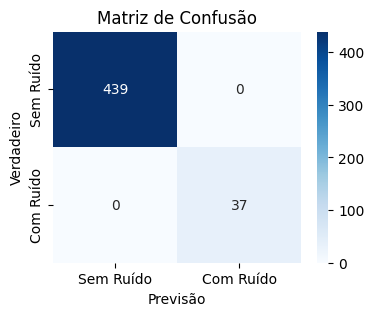

In [218]:
import seaborn as sns

cm = results_metrics.loc[results_metrics['k'] == selected_k, 'cm'].values[0]
print("Matriz de Confusão:\n", cm)

# Plotar a matriz de confusão com seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sem Ruído', 'Com Ruído'], yticklabels=['Sem Ruído', 'Com Ruído'])
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

### Obtenha a Acurácia, Precisão, Sensibilidade (recall), especificidade e F1Score

In [219]:
metrics = results_metrics.loc[results_metrics['k'] == selected_k]
print(f"\nMétricas de avaliação para o arquivo {device_833}")

print(f"Acurácia: {metrics['accuracy'].values[0]}")
print(f"Precisão: {metrics['precision'].values[0]}")
print(f"Sensibilidade (Recall): {metrics['recall'].values[0]}")
print(f"Especificidade: {metrics['specificity'].values[0]}")
print(f"F1 Score: {metrics['f1_score'].values[0]}")



Métricas de avaliação para o arquivo data-1740136119968-noise.csv
Acurácia: 1.0
Precisão: 1.0
Sensibilidade (Recall): 1.0
Especificidade: 1.0
F1 Score: 1.0


### Apresente a curva ROC

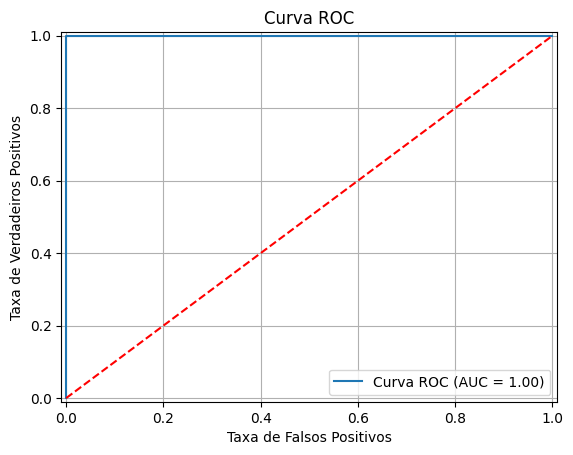

In [220]:
plot_roc_curve(model, X_test, y_test)

### Métricas do treinamento usando o arquivo *device_468*

In [221]:
df = load_file(device_468)
X = df[features] # seleciona as colunas de entrada
y = df[target] # seleciona a coluna de saída
test_size = 0.3 # 30% dos dados para teste
scale = False

results_metrics_468 = evaluate_knn(X, y, test_size=test_size, scale=scale)
print(f"\nMétricas de avaliação para o arquivo {device_468}")
print(results_metrics_468.drop(columns=['cm']))

selected_k_468 = 1
model, X_test, y_test, scaler = fit_model(X, y, test_size=0.3, scale=scale, n_neighbors=selected_k_468)



Métricas de avaliação para o arquivo data-1740190051056-noise.csv
     k  accuracy  precision  recall  specificity  f1_score
0    1  0.993506       0.75     0.6     0.997812  0.666667
1    2  0.993506       1.00     0.4     1.000000  0.571429
2    3  0.993506       1.00     0.4     1.000000  0.571429
3    4  0.993506       1.00     0.4     1.000000  0.571429
4    5  0.993506       1.00     0.4     1.000000  0.571429
5    6  0.991342       1.00     0.2     1.000000  0.333333
6    7  0.991342       1.00     0.2     1.000000  0.333333
7    8  0.989177       0.00     0.0     1.000000  0.000000
8    9  0.989177       0.00     0.0     1.000000  0.000000
9   10  0.989177       0.00     0.0     1.000000  0.000000
10  11  0.987013       0.00     0.0     0.997812  0.000000


### Comente os resultados com base na aplicação (dataset) utilizada  

Nesta atividade, utilizamos dois datasets. No primeiro dataset, foram gerados gráficos e avaliação de métricas, enquanto no segundo dataset realizamos apenas a avaliação das métricas do modelo.  

Treinamos o modelo para o arquivo device_833, variando o valor de *k* de 1 a 11, com o objetivo de comparar os resultados obtidos em cada modelo. Como todas as métricas atingiram 100% em todos os modelos, optamos pelo modelo com *k* = 1.

Repetimos o processo para o arquivo device_468 e, após avaliar os resultados, escolhemos o modelo com *k* = 2, pois os modelos com *k* maior apresentaram resultados iguais ou abaixo. A escolha ficou entre os modelos 1 e 2, sendo que o modelo 2 foi preferido por apresentar uma precisão melhor, que é o nosso principal critério de avaliação.

---

### Métricas de Avaliação  

#### Primeiro Treinamento  
Dataset: `data-1740136119968-noise.csv`  

- Acurácia: 1.0  
- Precisão: 1.0  
- Sensibilidade (Recall): 1.0  
- Especificidade: 1.0  
- F1 Score: 1.0  

O modelo apresentou acurácia, precisão, recall, especificidade e F1 Score máximos (100%), indicando que todas as amostras foram corretamente classificadas.


#### Segundo Treinamento  
Dataset: `data-1740190051056-noise.csv`  
- Acurácia: 0.9935  
- Precisão: 1.0  
- Sensibilidade (Recall): 0.4  
- Especificidade: 1.0  
- F1 Score: 0.57  

O modelo apresenta uma alta acurácia (99.35%) e precisão (100%), o que indica que ele é muito bom em prever amostras negativas (sem ruído).  

No entanto, a sensibilidade (recall) é baixa (40%), o que significa que o modelo não está identificando bem as amostras positivas (com ruído).  

A especificidade é alta (100%), indicando que o modelo conseguiu identificar todas as amostras negativas.  

Conclusão: O modelo foi bom em prever a ausência de ruído, porém precisa melhorar na detecção de ruído.
